In [1]:
# NOTE FOR LOCAL EXECUTION: use pytorch kernel and execute the code below to specify cuda device
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# BERT and Explainable AI

## Load required libraries

In [2]:
!pip install pandas
!pip install transformers
!pip install transformers-interpret

## Import libraries

In [1]:
from utils import *
import pandas as pd
import pickle
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

c:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\big_five\AGR\utils.py:10: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  auc_metric = load_metric("roc_auc", trust_remote_code=True)


## Load data

In [2]:
# Original data
#df = pd.read_csv(r"C:\Users\david\OneDrive - Universitat de Barcelona (1)\Documentos\GitHub\Explainability\essays.csv", encoding = "latin-1")

# Alternatively, load fragmented validation and test partitions
df_train = pd.read_csv(r"C:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\datasets\df_essays_fragm_train.csv")
df_valid = pd.read_csv(r"C:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\datasets\df_essays_fragm_valid.csv")
df_test = pd.read_csv(r"C:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\datasets\df_essays_fragm_test.csv")
#df = pd.concat([df_valid, df_test], axis=0, ignore_index=True)
df = df_test

# Another alternative, load training partition
#df = df_train

df.head()

#AUTHID                                               TEXT  cEXT  \
0  2000_999176.txt  spark up a conversation with a member of the o...     0   
1  1999_915632.txt  well I just got back from my home town in hunt...     0   
2  2000_515950.txt  that I would not be like the rest, but an indi...     0   
3  2000_935195.txt  So here are twenty minutes of Brian's thoughts...     0   
4  2000_933158.txt  know it they'll be a big nobody in the world. ...     1   

   cNEU  cAGR  cCON  cOPN  
0     1     0     0     1  
1     0     0     1     0  
2     1     0     0     1  
3     0     0     1     1  
4     1     1     1     1

In [3]:
print(len(df))

703


## Define Trait

In [3]:
trait = "cAGR"

## Load the fine-tuned model

In [4]:
# Path to the fine-tuned model
#model_path = r"C:\Users\david\OneDrive - Universitat de Barcelona (1)\Documentos\GitHub\Explainability\Agreeableness\results_agreeableness"  # my laptop
model_path = r"C:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\fine_tuning_models\results_agreeableness_fragm_roberta"

# Load the fine-tuned model and tokenizer
model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(model_path)
cls_explainer = SequenceClassificationExplainer(fine_tuned_model, tokenizer)
print(cls_explainer.device)

cpu


  0%|          | 0/88 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[[183 168]
 [120 232]]" of type <class 'numpy.ndarray'> for key "eval/conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6738170385360718, 'eval_accuracy': 0.5903271692745377, 'eval_roc_auc': 0.5902292152292152, 'eval_conf_matrix': array([[183, 168],
       [120, 232]], dtype=int64), 'eval_runtime': 606.2485, 'eval_samples_per_second': 1.16, 'eval_steps_per_second': 0.145}


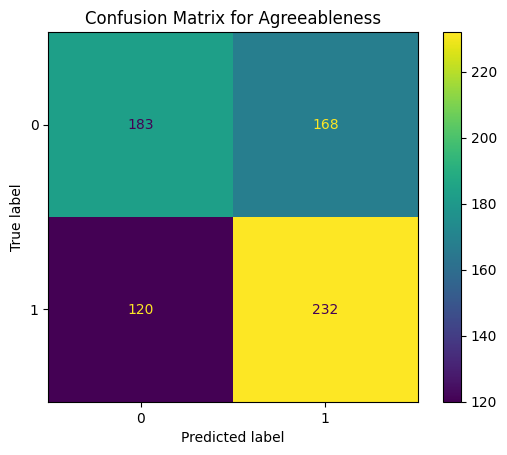

In [5]:
# Check that the models works correctly

# Create datasets
X_train, X_valid, y_train, y_valid = create_partition_from_split(df_train, df_valid, 'TEXT', trait)
_, X_test, _, y_test = create_partition_from_split(df_train, df_test, 'TEXT', trait)
train_dataset, valid_dataset = create_datasets(tokenizer, X_train, X_valid, y_train, y_valid)
_, test_dataset = create_datasets(tokenizer, X_train, X_test, y_train, y_test)

# Create trainer
trainer = Trainer(
        model=fine_tuned_model,          # the instantiated Transformers model to be trained
        args=None,                       # training arguments
        train_dataset=train_dataset,     # training dataset
        eval_dataset=test_dataset,      # evaluation dataset
        compute_metrics=compute_metrics, # the callback that computes metrics of interest
        #optimizers=(optimizer, None)
    )

# Evaluate the model and get the confusion matrix
results = trainer.evaluate()
conf_matrix = results['eval_conf_matrix']
print(results)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

# Add a title to the confusion matrix plot
plt.title("Confusion Matrix for Agreeableness")
plt.show()

In [ ]:
import pickle

# Set the desired maximum sequence length
max_sequence_length = 512
attribution_threshold = 0.5  # Adjust the threshold as needed

# List to store word attributions for each row
all_word_attributions = []

# List to store sum of attributions for each row
all_sum_attributions = []

# Loop through all rows in the dataset
print("Number of rows:", len(df))
for row_index in range(len(df)):
    # Show progress every 100 sentences
    if row_index%100 == 0:
        print(row_index)

    preproc_text = get_preproc_text(df, row_index, tokenizer, max_sequence_length)
    word_attributions = cls_explainer(preproc_text)
    true_class = df.loc[row_index, trait]
    predicted_class = cls_explainer.predicted_class_name

    # Print the terms with scores greater than the threshold
    for token, score in word_attributions:
        if abs(score) > attribution_threshold:
            print(f'Token: {token}, Score: {score}')

    # Save the filtered attributions for this row along with true_class and predicted_class
    attribution_info = (word_attributions, true_class, predicted_class)
    all_word_attributions.append(attribution_info)

    # Visualize if there are filtered attributions
    if any(abs(score) > attribution_threshold for _, score in word_attributions):
        cls_explainer.visualize(true_class=true_class)
    
    # Sum of attributions for the entire text
    sum_attribution = cls_explainer.attributions.attributions_sum.sum()

    # Save the sum of attributions for this row
    all_sum_attributions.append((sum_attribution.item(), true_class, predicted_class))
        
# Save all_word_attributions to a file
word_attr_fname = get_all_word_attr_fname_essays(trait)
with open(word_attr_fname, 'wb') as file:
    pickle.dump(all_word_attributions, file)

# Save all_sum_attributions to a file
sum_attr_fname = get_all_sum_attr_fname_essays(trait)
with open(sum_attr_fname, 'wb') as file:
    pickle.dump(all_sum_attributions, file)

In [5]:
import pickle

word_attr_fname = get_all_word_attr_fname_essays(trait)
sum_attr_fname = get_all_sum_attr_fname_essays(trait)

# Load the previously saved attributions from the file
with open(word_attr_fname, 'rb') as file:
    all_word_attributions = pickle.load(file)

# Load the previously saved attributions from the file
with open(sum_attr_fname, 'rb') as file:
    all_sum_attributions = pickle.load(file)

## Obtain Word Frequencies 

In [6]:
word_freq = get_word_freqs(all_word_attributions)
word_freq_label_1 = get_word_freqs(all_word_attributions, "LABEL_1")
word_freq_label_0 = get_word_freqs(all_word_attributions, "LABEL_0")

## Obtain Positive and Negative Attributions

In [7]:
# Get positive and negative attributions for the two labels
force_correct_classif=True
positive_attributions_label_1 = filter_attributions(all_word_attributions, '+', "LABEL_1", force_correct_classif)
positive_attributions_label_0 = filter_attributions(all_word_attributions, '+', "LABEL_0", force_correct_classif)
negative_attributions_label_1 = filter_attributions(all_word_attributions, '-', "LABEL_1", force_correct_classif)
negative_attributions_label_0 = filter_attributions(all_word_attributions, '-', "LABEL_0", force_correct_classif)
print(len(positive_attributions_label_1))

42823


## Word Filtering Functions

In [8]:
#!pip install nltk

import nltk
from nltk.corpus import stopwords

# Obtain stop words
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
#print(english_stopwords)

# Obtain list of words
nltk.download('words')
english_words = set(nltk.corpus.words.words())
#print(len(english_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Word Clouds
### By attribution score

In [10]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

min_word_freq = 10
min_word_len = 4
sum_techniques = ["freq", "avg", "max", "accum", "gmean"]
#sum_techniques = ["avg"]

for sum_technique in sum_techniques:

    # Create separate lists for positive and negative attributions for LABEL_1
    filtered_words = filter_words(english_words, english_stopwords, word_freq_label_1, positive_attributions_label_1, min_word_freq, min_word_len)
    positive_words_label_1 = summarize_scores(filtered_words, sum_technique)
    filtered_words = filter_words(english_words, english_stopwords, word_freq_label_1, negative_attributions_label_1, min_word_freq, min_word_len)
    negative_words_label_1 = summarize_scores(filter_words(english_words, english_stopwords, word_freq, negative_attributions_label_1), sum_technique)

    # Create separate lists for positive and negative attributions for LABEL_0
    filtered_words = filter_words(english_words, english_stopwords, word_freq_label_0, positive_attributions_label_0, min_word_freq, min_word_len)
    positive_words_label_0 = summarize_scores(filtered_words, sum_technique)
    filtered_words = filter_words(english_words, english_stopwords, word_freq_label_0, negative_attributions_label_0, min_word_freq, min_word_len)
    negative_words_label_0 = summarize_scores(filtered_words, sum_technique)

    # Generate word clouds
    wordcloud_label_1_positive = WordCloud(background_color='white').generate_from_frequencies(positive_words_label_1)
    wordcloud_label_1_negative = WordCloud(background_color='white').generate_from_frequencies(negative_words_label_1)
    wordcloud_label_0_positive = WordCloud(background_color='white').generate_from_frequencies(positive_words_label_0)
    wordcloud_label_0_negative = WordCloud(background_color='white').generate_from_frequencies(negative_words_label_0)

    # Plot word clouds
    fig = plt.figure(figsize=(16, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(wordcloud_label_1_positive, interpolation='bilinear')
    plt.title(trait + ": Word Cloud for Positive Attributions (LABEL_1) " + sum_technique)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(wordcloud_label_1_negative, interpolation='bilinear')
    plt.title(trait + ": Word Cloud for Negative Attributions (LABEL_1) " + sum_technique)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(wordcloud_label_0_positive, interpolation='bilinear')
    plt.title(trait + ": Word Cloud for Positive Attributions (LABEL_0) " + sum_technique)
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(wordcloud_label_0_negative, interpolation='bilinear')
    plt.title(trait + ": Word Cloud for Negative Attributions (LABEL_0) " + sum_technique)
    plt.axis('off')

    plt.tight_layout()
    
    # Save the figure as a high-resolution image
    filename = f"Wordclouds_AGR_{sum_technique}.png"
    plt.savefig(filename, dpi = 300, bbox_inches = "tight")
    plt.close(fig)

## Barplots

In [9]:
min_word_freq = 10
sum_technique = "gmean"
# Create separate lists for positive and negative attributions for LABEL_1
filtered_words = filter_words(english_words, english_stopwords, word_freq_label_1, positive_attributions_label_1, min_word_freq)
positive_words_label_1 = summarize_scores(filtered_words, sum_technique)
filtered_words = filter_words(english_words, english_stopwords, word_freq_label_1, negative_attributions_label_1, min_word_freq)
negative_words_label_1 = summarize_scores(filter_words(english_words, english_stopwords, word_freq, negative_attributions_label_1), sum_technique)

# Create separate lists for positive and negative attributions for LABEL_0
filtered_words = filter_words(english_words, english_stopwords, word_freq_label_0, positive_attributions_label_0, min_word_freq)
positive_words_label_0 = summarize_scores(filtered_words, sum_technique)
filtered_words = filter_words(english_words, english_stopwords, word_freq_label_0, negative_attributions_label_0, min_word_freq)
negative_words_label_0 = summarize_scores(filtered_words, sum_technique)

# Plot horizontal bar plots for each category with both top and bottom significant words
plot_bar(positive_words_label_1, 'Positive Attributions (LABEL_1)', filename = "positive_label_1_barplot.png")
plot_bar(negative_words_label_1, 'Negative Attributions (LABEL_1)', filename = "negative_label_1_barplot.png")
plot_bar(positive_words_label_0, 'Positive Attributions (LABEL_0)', filename = "positive_label_0_barplot.png")
plot_bar(negative_words_label_0, 'Negative Attributions (LABEL_0)', filename = "negative_label_0_barplot.png")

Saved positive_label_1_barplot.png
Saved negative_label_1_barplot.png
Saved positive_label_0_barplot.png
Saved negative_label_0_barplot.png


## Histogram

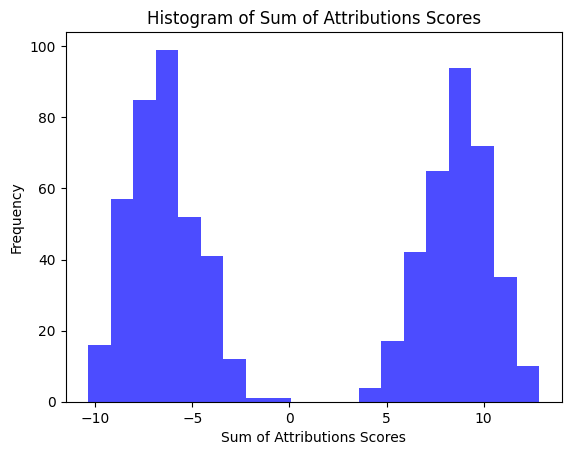

In [15]:
import matplotlib.pyplot as plt

# Create a histogram
filtered_sum_attributions = filter_sum_attributions(all_sum_attributions)
plt.hist(filtered_sum_attributions, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Sum of Attributions Scores')
plt.xlabel('Sum of Attributions Scores')
plt.ylabel('Frequency')
plt.show()

Percentile value: -6.718245919202487
Percentile value: -3.2677893498695463
Percentile value: 8.634707363158547


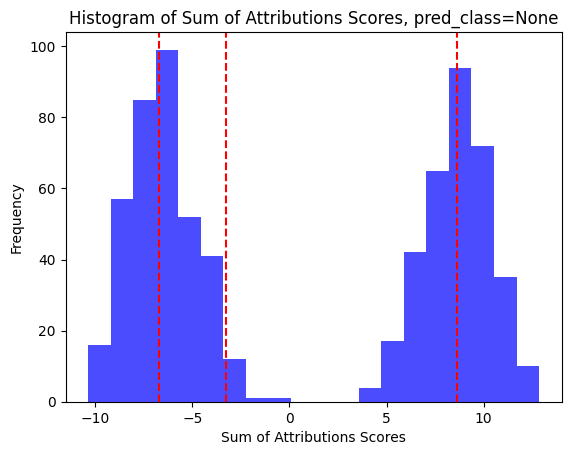

Percentile value: 7.560492003754647
Percentile value: 8.68177038169088
Percentile value: 9.744716118935772


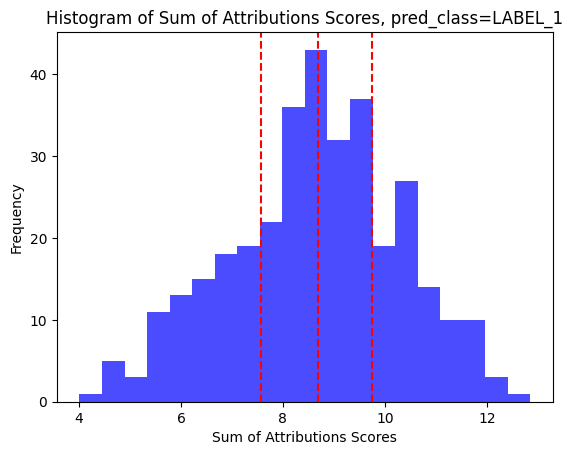

Percentile value: -7.8401021677312315
Percentile value: -6.653867843824571
Percentile value: -5.449466146234122


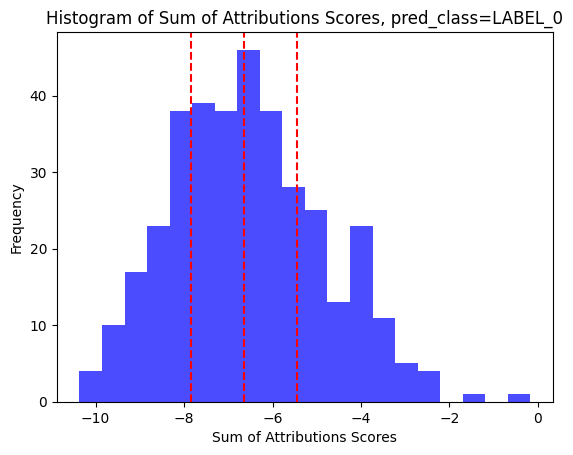

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Create histograms
for pred_class in [None, "LABEL_1", "LABEL_0"]:
    sum_attributions = filter_sum_attributions(all_sum_attributions, pred_class=pred_class)
    hist, bins, _ = plt.hist(sum_attributions, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of Sum of Attributions Scores, pred_class=' + str(pred_class))
    plt.xlabel('Sum of Attributions Scores')
    plt.ylabel('Frequency')

    # Calculate the percentiles
    percentiles = np.percentile(sum_attributions, [25, 50, 75])

    # Print the percentile values
    for percentile_value in percentiles:
        print("Percentile value:", percentile_value)

    # Draw red lines at the percentile values
    for percentile_value in percentiles:
        plt.axvline(percentile_value, color='red', linestyle='--')

    plt.show()

## Texts: highest scores

In [ ]:
import numpy as np

# Set the desired maximum sequence length
max_sequence_length = 512

# Calculate the percentiles
# percentiles = np.percentile(all_total_attributions, [25, 75])

# Set the attribution threshold as the first and third percentile values
# attribution_threshold_lower = percentiles[0]
# attribution_threshold_upper = percentiles[1]

attribution_threshold_lower = -1.2264066739414712
attribution_threshold_upper = 3.9756553009835245

# Loop through all rows in the dataset
for row_index in range(len(df)):
    # Sum of attributions for the entire text
    sum_attribution = all_sum_attributions[row_index][0]

    # Check if the total attribution falls within the specified thresholds
    if abs(sum_attribution) < attribution_threshold_lower or abs(sum_attribution) > attribution_threshold_upper:
        # Extract row information
        preproc_text = get_preproc_text(df, row_index, tokenizer, max_sequence_length)
        word_attributions = cls_explainer(preproc_text)
        true_class = df.loc[row_index, trait]
        predicted_class = cls_explainer.predicted_class_name
        
        # Save the filtered attributions for this row
        attribution_info = (sum_attribution, true_class, predicted_class)

        # Print the information only for rows meeting the threshold
        print(f'True Class for Row {row_index}: {true_class}')
        print(f'Total Attribution for Row {row_index}: {sum_attribution}')

        # Visualize if needed
        if abs(sum_attribution) < attribution_threshold_lower or abs(sum_attribution) > attribution_threshold_upper:
            cls_explainer.visualize(true_class=true_class)


## Visualize sorted lists (explainer)

In [9]:
# Set the desired maximum sequence length
max_sequence_length = 512

# Obtain attributions
for pred_class in ["LABEL_1", "LABEL_0"]:

    sum_attributions = filter_sum_attributions(all_sum_attributions, pred_class=pred_class, get_attr_plus_idx=True)
    
    # Sort attributions
    sorted_list = sorted(sum_attributions, key=lambda x: x[0], reverse=True)

    # Visualize the attributions for the texts corresponding to the highest and lowest total attribution scores
    num_elements_to_show=10
    for element in sorted_list[:num_elements_to_show]:
        # Extract row information
        row_index = element[1]
        preproc_text = get_preproc_text(df, row_index, tokenizer, max_sequence_length)
        word_attributions = cls_explainer(preproc_text)
        true_class = df.loc[row_index, trait]
        predicted_class = cls_explainer.predicted_class_name

        # Sum of attributions for the entire text
        sum_attribution = cls_explainer.attributions.attributions_sum.sum()

        print(all_sum_attributions[row_index], sum_attribution)

        # Visualize the attributions for the text
        cls_explainer.visualize(true_class=true_class)

(12.85552252246612, 1, 'LABEL_1') tensor(12.8555, dtype=torch.float64)


(12.390198822968307, 1, 'LABEL_1') tensor(12.3902, dtype=torch.float64)


(12.26464192277053, 1, 'LABEL_1') tensor(12.2646, dtype=torch.float64)


(12.10784836357146, 0, 'LABEL_1') tensor(12.1079, dtype=torch.float64)


(11.94434840241131, 1, 'LABEL_1') tensor(11.9443, dtype=torch.float64)


(11.932804845828969, 1, 'LABEL_1') tensor(11.9328, dtype=torch.float64)


(11.844190374126427, 1, 'LABEL_1') tensor(11.8442, dtype=torch.float64)


(11.802881733422845, 0, 'LABEL_1') tensor(11.8029, dtype=torch.float64)


(11.779694432397793, 1, 'LABEL_1') tensor(11.7793, dtype=torch.float64)


(11.771760893340206, 1, 'LABEL_1') tensor(11.7718, dtype=torch.float64)


(-0.16843268039993958, 0, 'LABEL_0') tensor(-0.1684, dtype=torch.float64)


(-1.2720822375778358, 0, 'LABEL_0') tensor(-1.2721, dtype=torch.float64)


(-2.3940668792611146, 0, 'LABEL_0') tensor(-2.3942, dtype=torch.float64)


(-2.487493664309691, 0, 'LABEL_0') tensor(-2.4875, dtype=torch.float64)


(-2.5407328233213367, 1, 'LABEL_0') tensor(-2.5401, dtype=torch.float64)


(-2.7119689292840663, 1, 'LABEL_0') tensor(-2.7122, dtype=torch.float64)


(-2.873350400269084, 0, 'LABEL_0') tensor(-2.8734, dtype=torch.float64)


(-2.9771970066661053, 0, 'LABEL_0') tensor(-2.9772, dtype=torch.float64)


(-3.0115856040149627, 0, 'LABEL_0') tensor(-3.0114, dtype=torch.float64)


(-3.1823661286143294, 0, 'LABEL_0') tensor(-3.1824, dtype=torch.float64)


## Trial

In [12]:
# Define a function to get the HTML file name
def get_html_fname(pred_class):
    return 'attributions_' + pred_class + '.html'

# Set the desired maximum sequence length
max_sequence_length = 512

# Initialize the HTML content
html_content = "<html><head><title>Essays with highest scores</title></head><body>"

# Obtain attributions
for pred_class in ["LABEL_1", "LABEL_0"]:

    sum_attributions = filter_sum_attributions(all_sum_attributions, pred_class=pred_class, get_attr_plus_idx=True)
    
    # Sort attributions
    sorted_list = sorted(sum_attributions, key=lambda x: x[0], reverse=True)

    # Visualize the attributions for the texts corresponding to the highest and lowest total attribution scores
    num_elements_to_show=10
    for element in sorted_list[:num_elements_to_show]:
        # Extract row information
        row_index = element[1]
        preproc_text = get_preproc_text(df, row_index, tokenizer, max_sequence_length)
        word_attributions = cls_explainer(preproc_text)
        true_class = df.loc[row_index, trait]
        predicted_class = cls_explainer.predicted_class_name

        # Sum of attributions for the entire text
        sum_attribution = cls_explainer.attributions.attributions_sum.sum()

        # Add the information to the HTML content
        html_content += f"<p>{all_sum_attributions[row_index]}, {sum_attribution}</p>"

        # Visualize the attributions for the text
        explanation_html = cls_explainer.visualize(true_class=true_class).data

        # Add the text to the HTML content
        html_content += str(explanation_html)

    # Close the HTML content
    html_content += "</body></html>"

    # Get the HTML file name
    html_fname = get_html_fname(pred_class)

    # Save the collected HTML content to a file
    with open(html_fname, 'w') as file:
        file.write(html_content)

    # Reset the HTML content for the next pred_class
    html_content = "<html><body>"

## Visualize sentences with a particular word (sum attribution ordering)

In [9]:
def get_html_fname_essays(word_of_interest):
    return 'gmean_essay_' + word_of_interest.replace("/", "_") + '.html'

# Set the desired maximum sequence length
max_sequence_length = 512

# Define the list of words of interest and other parameters
words_of_interest = ["dead", "really", "lack", "smoking", "little"]
pred_class_of_interest = "LABEL_0"
max_elements_to_show = 10

for word_of_interest in words_of_interest:
    # Get filtered sum attributions
    sum_attributions = filter_sum_attributions(all_sum_attributions, pred_class=pred_class_of_interest, get_attr_plus_idx=True)
    
    # Sort attributions
    sorted_list = sorted(sum_attributions, key=lambda x: x[0], reverse=True)

    # Initialize HTML content string
    html_content = "<html><head><title>Word Attribution Scores</title></head><body>"

    num_elem = 0
    for element in sorted_list:
        # Extract row information
        row_index = element[1]
        
        word_attributions = all_word_attributions[row_index]
            
        # Check if word is contained in the current sentence
        score = get_max_word_score(word_of_interest, word_attributions)
        if score is not None:
            # Extract row information
            preproc_text = get_preproc_text(df, row_index, tokenizer, max_sequence_length)
            word_attributions = cls_explainer(preproc_text)
            true_class = df.loc[row_index, trait]
            predicted_class = cls_explainer.predicted_class_name
            
            # Print score
            print(word_of_interest, "score:", score)

            # Visualize and collect HTML content
            explanation_html = cls_explainer.visualize(true_class=true_class).data
            html_content += f"<h3>{word_of_interest} score: {score}</h3>"
            html_content += str(explanation_html)  # Ensure conversion to string
            
            num_elem += 1
            if num_elem == max_elements_to_show:
                break

    # Close the HTML content
    html_content += "</body></html>"

    # Close the HTML file name
    html_fname = get_html_fname_essays(word_of_interest)

    # Save the collected HTML content to a file
    with open(html_fname, 'w') as file:
        file.write(html_content)

dead score: 0.7657748237731781


dead score: -0.3540692375361489


dead score: -0.08374284939875182


dead score: -0.09753587787575645


dead score: -0.14831965801068697


dead score: -0.16780106040268156


dead score: -0.14655515890544504


dead score: -0.15573416182010766


dead score: -0.24072216567476104


really score: -0.014027576563199059


really score: 0.03446525437957687


really score: 0.053147432545424395


really score: 0.04121329855016915


really score: 0.060221124561390664


really score: 0.09396630160691175


really score: 0.013408543871876056


really score: 0.026340729354881597


really score: 0.05730651913735655


really score: 0.04489293205479984


lack score: 0.004470133403904222


lack score: 0.6739043584269668


lack score: 0.03067590256778479


lack score: -0.07482131784720325


lack score: 0.000966012118909493


lack score: -0.08096911915962499


lack score: -0.2098842956558279


smoking score: 0.6046663838247981


smoking score: -0.24638994110189405


smoking score: 0.03831141731019452


smoking score: -0.030420602003235663


smoking score: -0.02842635966459465


little score: 0.02501739149086009


little score: -0.017006340362122167


little score: -0.013366854847103956


little score: 0.019048496881605384


little score: 0.018944243359128917


little score: 0.01933489183967128


little score: -0.01132587184298611


little score: 0.02451669868640738


little score: -0.021433712438433346


little score: 0.05931919014602432


## Visualize sentences with a particular word (word attribution ordering)

In [10]:
def get_html_fname_essays(word_of_interest):
    return 'gmean_word_' + word_of_interest.replace("/", "_") + '.html'

# Set the desired maximum sequence length
max_sequence_length = 512

# Define the list of words of interest and other parameters
words_of_interest = ["dead", "really", "lack", "smoking", "little"]
pred_class_of_interest = "LABEL_0"
max_elements_to_show = 10

for word_of_interest in words_of_interest:
    # Get word score info
    word_scores = get_max_word_scores(word_of_interest, all_word_attributions, pred_class_of_interest)

    # Sort word scores
    sorted_list = sorted(word_scores, key=lambda x: x[0], reverse=True)

    # Initialize HTML content string
    html_content = "<html><head><title>Word Attribution Scores</title></head><body>"

    for element in sorted_list[:max_elements_to_show]:
        # Extract row information
        row_index = element[1]
        
        word_attributions = all_word_attributions[row_index]
            
        # Check if word is contained in the current sentence
        score = get_max_word_score(word_of_interest, word_attributions)
        
        # Extract row information
        preproc_text = get_preproc_text(df, row_index, tokenizer, max_sequence_length)
        word_attributions = cls_explainer(preproc_text)
        true_class = df.loc[row_index, trait]
        predicted_class = cls_explainer.predicted_class_name
            
        # Print score
        print(word_of_interest, "score:", score)

        # Visualize and collect HTML content
        explanation_html = cls_explainer.visualize(true_class=true_class).data
        html_content += f"<h3>{word_of_interest} score: {score}</h3>"
        html_content += explanation_html

    # Close HTML content string
    html_content += "</body></html>"

    # Get the HTML file name
    html_fname = get_html_fname_essays(word_of_interest)

    # Save the collected HTML content to a file
    with open(html_fname, 'w') as file:
        file.write(html_content)

dead score: 0.7657748237731781


dead score: -0.08374284939875182


dead score: -0.09753587787575645


dead score: -0.14655515890544504


dead score: -0.14831965801068697


dead score: -0.15573416182010766


dead score: -0.16780106040268156


dead score: -0.24072216567476104


dead score: -0.3540692375361489


really score: 0.19639989978746378


really score: 0.14584373058570416


really score: 0.11370836441639019


really score: 0.10648280737191901


really score: 0.10640115494674618


really score: 0.10496508546543945


really score: 0.10481778766493471


really score: 0.09396630160691175


really score: 0.09213787475223763


really score: 0.09119519510373668


lack score: 0.6739043584269668


lack score: 0.03067590256778479


lack score: 0.004470133403904222


lack score: 0.000966012118909493


lack score: -0.07482131784720325


lack score: -0.08096911915962499


lack score: -0.2098842956558279


smoking score: 0.6046663838247981


smoking score: 0.03831141731019452


smoking score: -0.02842635966459465


smoking score: -0.030420602003235663


smoking score: -0.24638994110189405


little score: 0.1708841894060948


little score: 0.16313198434232584


little score: 0.13687496202964214


little score: 0.13503443975867363


little score: 0.09350789147526782


little score: 0.09158305899797817


little score: 0.08901925591608123


little score: 0.08787695570280978


little score: 0.08081231546935978


little score: 0.07259162930984371
